#Todos


Data
- Load Data
- Preprocessing? (Stop Words, Links, User Names, HTML Tags)

Topic Model
- LDA (Latent Dirichlet Allocation)


Model Evaluation:
- Print Results: Topics, Topic Members (e.g. nearest neighbour document) (https://asistdl.onlinelibrary.wiley.com/doi/full/10.1002/asi.23786
)

- global (topic coherence, topic diversity)
- instance based/local
- features


Contextual Embeddings
- USE (https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=RUymE2l9GZfO)
- Dimensionality reduction (PCA, (UMAP), MDS) (Curse of dimensionality)
- Clustering (Choose method: k-means, spectral, density-based methods https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction to 2D (T-SNE, UMAP)
- make interactive map?

Model Evaluation:
- global
- instance based/local
- features

##Load Data

In [1]:
import os

os.chdir(os.path.expanduser('~'))
import gdown
zip_folder_name = 'youtube_comments_climate_change'

shared_google_drive_link = 'https://drive.google.com/uc?id=17-eCljAzaqKwy7Fd9kXAmdmkOVSZzDeE'
output = zip_folder_name+'.zip'
gdown.download(shared_google_drive_link,output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('')


os.chdir(zip_folder_name) 

data_desciption_file = 'data_description.txt'

with open(data_desciption_file,'r') as myfile:
  f = myfile.read()
print(f)

Downloading...
From: https://drive.google.com/uc?id=17-eCljAzaqKwy7Fd9kXAmdmkOVSZzDeE
To: /root/youtube_comments_climate_change.zip
5.32MB [00:00, 43.2MB/s]


Data description
__________________

// Project
data deluge

// Data mining
All data are extracted using the YouTube Data Tools (YTDT):
https://tools.digitalmethods.net/netvizz/youtube/
Specifically, comments are extracted using the video info and comments module
https://tools.digitalmethods.net/netvizz/youtube/mod_video_info.php

// Datasets

- videoinfo_xE0KtLy5j8w_2018_06_26-18_32_17_comments.xlsx
This dataset includes all text posted within the comments section of the video https://youtu.be/xE0KtLy5j8w (produced by Climate Central, featured by The Daily Conversation)
Additional variables such as time of posting, replies, likes, etc. have been removed from the dataset.
The comments were then coded by hand, in order to identify particular coping strategies of people making sense of the information shown in the video (sea level rise scenarios).

- videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab
Data gathered from the video https://youtu.be/VbiRNT_gWUQ, produced by the National 

#### Display zip contents

In [2]:
zip_ref.printdir()

File Name                                             Modified             Size
youtube_comments_climate_change/               2020-06-05 15:59:54            0
youtube_comments_climate_change/500_comments_raw.csv 2020-04-19 14:34:02       116060
youtube_comments_climate_change/videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab 2020-04-19 14:34:02      7268174
youtube_comments_climate_change/videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab - videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab.csv 2020-04-19 14:34:02      7310945
youtube_comments_climate_change/data_description.txt 2020-04-19 14:34:02         1178
youtube_comments_climate_change/lda_tuning_results.csv 2020-05-13 14:45:10        13802
youtube_comments_climate_change/500_comments_raw.xlsx 2020-04-19 14:34:02        80887


### Open file as df and list columns



In [3]:
import pandas as pd


path = "videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab - videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')
data = data.dropna(subset=['text', 'authorName']) # drop rows with no content

list(data.columns)

['id',
 'replyCount',
 'likeCount',
 'publishedAt',
 'authorName',
 'text',
 'authorChannelId',
 'authorChannelUrl',
 'isReply',
 'isReplyTo',
 'isReplyToName']

### Removing unused columns

In [4]:
data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1)
data.head()

,publishedAt,authorName,text,isReply
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the ea...,0
1,2020-01-16 06:16:07,Aakash Majumdar,The scariest part of the video is the music......,0
2,2020-01-15 10:50:21,Glenn Davies,New Zealand be like...&quot;are we good?&quot;...,0
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Utopia,0
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson&#39;s Bay stayed the same s...,0


## Preprocessing

### Removing HTML tags

In [5]:
!pip3 install html2text

In [6]:
from html2text import HTML2Text
from tqdm import tqdm

tqdm.pandas()

h = HTML2Text()
h.ignore_links = True

data['text'] = data['text'].progress_apply(lambda x: h.handle(x))

100%|██████████| 25914/25914 [00:02<00:00, 10567.36it/s]


### Removing links

In [7]:
http_link_pattern = r'http\S+'
bitly_link_pattern = r'bit.ly/\S+'
data['text'] = data['text'].str.replace(http_link_pattern, '')
data['text'] = data['text'].str.replace(bitly_link_pattern, '')

### Removing user names

Only user names consisting of more than 3 characters are removed to avoid unintentionally joining words.

In [8]:
import re

keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]

data['cleaned'] = data['text'].str.replace('|'.join(map(re.escape, user_names)), '')

## Topic Modelling

### Tokenizing



In [9]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_text(text):
    text = text.lower()
    text = re.sub('['+punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) # remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    return text

In [10]:
import nltk
#nltk.download('punkt')
from tqdm import tqdm
import gensim
from gensim.utils import simple_preprocess

tqdm.pandas()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_cleaned = data['cleaned'].progress_apply(clean_text)
data_words = list(sent_to_words(data_cleaned))

100%|██████████| 25914/25914 [00:00<00:00, 58300.66it/s]


Every comment ends up as a "cleaned" list of words.

In [11]:
data_words[0]

['if',
 'all',
 'the',
 'ice',
 'melts',
 'surely',
 'the',
 'tilt',
 'of',
 'the',
 'earth',
 'will',
 'also',
 'change',
 'because',
 'of',
 'the',
 'weight',
 'diffrence',
 'at',
 'both',
 'poles',
 'and',
 'would',
 'this',
 'affect',
 'the',
 'land',
 'mass',
 'to',
 'change',
 'also']

### N-grams

An n-gram is a contiguous sequence of items in this case words. A bigram consists of two words, a trigram of three words.

The gensim Phrase detection automatically detects common sequences.

Important params for these n-grams are min_count and threshold. The higher these params harder it is for words to be combined. 

In [12]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

# Exporting the trained model means faster processing BUT model updates no longer possible.
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Removing stop words, lemmatization

> TODO: Use different stop word lists or extend existing list?

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(elem)) if word not in stop_words] for elem in texts]

def make_bigrams(texts):
    return [bigram_mod[elem] for elem in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


During lemmatization only nouns, adjectives, verbs, and adverbs are kept.

In [14]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
data_lemmatized[0]

['ice',
 'melt',
 'surely',
 'tilt',
 'earth',
 'also',
 'change',
 'weight',
 'diffrence',
 'pole',
 'would',
 'affect',
 'land',
 'mass',
 'change',
 'also']

### LDA

The gensim LDA model needs dictionary(id2word) and corpus. The dictionary creates an unique id for all words, the corpus maps the id to the number of occurences in the model.

In [17]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
corpus[0]

[(0, 1),
 (1, 2),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1)]

In [19]:
id2word[0]

'affect'

In [20]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affect', 1),
  ('also', 2),
  ('change', 2),
  ('diffrence', 1),
  ('earth', 1),
  ('ice', 1),
  ('land', 1),
  ('mass', 1),
  ('melt', 1),
  ('pole', 1),
  ('surely', 1),
  ('tilt', 1),
  ('weight', 1),
  ('would', 1)]]

Aside from corpus and dictionary, the model takes the number of topics, chunksize (number of documents to be used in each training chunk increasing chunksize speed up training), and passes (epochs) as input.

In [ ]:
num_topics = 10
chunksize = 100
passes = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=chunksize,
                                       passes=passes,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"look" + 0.066*"would" + 0.050*"bad" + 0.039*"flood" + 0.035*"happen" '
  '+ 0.034*"lol" + 0.033*"go" + 0.032*"think" + 0.031*"place" + 0.026*"state"'),
 (1,
  '0.049*"make" + 0.038*"video" + 0.029*"area" + 0.023*"problem" + '
  '0.020*"music" + 0.019*"care" + 0.016*"leave" + 0.016*"last" + '
  '0.015*"survive" + 0.014*"right"'),
 (2,
  '0.055*"city" + 0.045*"get" + 0.043*"still" + 0.037*"good" + 0.027*"big" + '
  '0.022*"need" + 0.021*"give" + 0.020*"thing" + 0.017*"find" + '
  '0.017*"canadian"'),
 (3,
  '0.044*"say" + 0.039*"people" + 0.033*"much" + 0.031*"many" + 0.022*"die" + '
  '0.020*"life" + 0.018*"pretty" + 0.017*"want" + 0.016*"energy" + '
  '0.016*"seem"'),
 (4,
  '0.041*"know" + 0.028*"even" + 0.027*"go" + 0.024*"time" + 0.024*"come" + '
  '0.022*"think" + 0.020*"world" + 0.018*"really" + 0.017*"move" + '
  '0.017*"fuck"'),
 (5,
  '0.122*"water" + 0.100*"ice" + 0.045*"melt" + 0.036*"would" + 0.034*"show" + '
  '0.029*"land" + 0.024*"level" + 0.021*"take" + 0.

In [ ]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # the lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.088845491208266

Coherence Score:  0.5015008041333983


### Hyperparameter Tuning

Alpha and beta are hyperparameters that affect sparsity of the topics

[As seen here.](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

**The script runs for about 1:50.**

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  0%|          | 0/270 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
 57%|█████▋    | 154/270 [4:07:30<3:17:53, 102.36s/it]

### Analyzing results of hyperparameter tuning

In [21]:
path = "lda_tuning_results.csv"
lda_results = pd.read_csv(path, sep=",", encoding='utf-8')

list(lda_results.columns)

['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence']

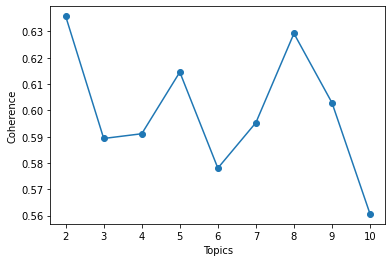

In [22]:
import matplotlib.pyplot as plt
import numpy as np

coherence = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Coherence']
topics = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Topics']

plt.plot(topics, coherence, linestyle='-', marker='o')
plt.ylabel('Coherence')
plt.xlabel('Topics')
plt.show()

In [23]:
lda_results.loc[lda_results.Topics == 8][['Topics', 'Alpha', 'Beta', 'Coherence']]

,Topics,Alpha,Beta,Coherence
180,8,0.01,0.01,0.629238
181,8,0.01,0.31,0.525422
182,8,0.01,0.61,0.594439
183,8,0.01,0.9099999999999999,0.550440
184,8,0.01,symmetric,0.591427
185,8,0.31,0.01,0.532120
186,8,0.31,0.31,0.518596
187,8,0.31,0.61,0.515139
188,8,0.31,0.9099999999999999,0.505914
189,8,0.31,symmetric,0.545217


In [24]:
lda_results.loc[lda_results['Coherence'].idxmax()]

Validation_Set    100% Corpus
Topics                      3
Alpha              asymmetric
Beta                     0.31
Coherence            0.705983
Name: 56, dtype: object

In [25]:
tuned_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=0.01)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [26]:
from pprint import pprint

pprint(tuned_lda_model.print_topics())
doc_tuned_lda = tuned_lda_model[corpus]

[(0,
  '0.049*"go" + 0.043*"would" + 0.023*"think" + 0.023*"people" + 0.023*"world" '
  '+ 0.022*"get" + 0.022*"know" + 0.020*"live" + 0.019*"look" + '
  '0.019*"happen"'),
 (1,
  '0.071*"make" + 0.046*"take" + 0.031*"lot" + 0.029*"right" + 0.026*"use" + '
  '0.026*"put" + 0.024*"area" + 0.024*"already" + 0.024*"care" + 0.022*"let"'),
 (2,
  '0.134*"water" + 0.108*"ice" + 0.076*"level" + 0.062*"sea" + 0.048*"melt" + '
  '0.048*"would" + 0.046*"rise" + 0.039*"land" + 0.026*"ocean" + 0.020*"high"'),
 (3,
  '0.072*"say" + 0.052*"year" + 0.034*"planet" + 0.029*"science" + '
  '0.027*"time" + 0.027*"become" + 0.025*"earth" + 0.024*"man" + 0.023*"come" '
  '+ 0.022*"give"')]


### Visual representation

Each blue circle represents a topic. The larger the bubble, the more prevalent the topic.

Relatively big, non-overlapping bubbles scattered throughout the chart are desirable.

By decreasing the value of lamda, more weight is put on the ratio of frequency given the topic to overall frequency of the word.

In [28]:
!pip3 install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 15.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=eb27fbf36e0a4e7d93a9cd122090ce6823e49304196c236ea1a354896cc2ca10
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3ea99ab44456d452c2be0cfc25dae840161f903927c3f4d85e521603c194fb15
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [29]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(tuned_lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.214322  0.081084       1        1  46.397545
2     -0.267823 -0.158013       2        1  21.014378
1      0.315610 -0.253246       3        1  17.177122
3      0.166535  0.330175       4        1  15.410953, topic_info=       Term         Freq        Total Category  logprob  loglift
51    water  5045.000000  5045.000000  Default  30.0000  30.0000
5       ice  4054.000000  4054.000000  Default  29.0000  29.0000
73    level  2856.000000  2856.000000  Default  28.0000  28.0000
42     make  2191.000000  2191.000000  Default  27.0000  27.0000
91      say  1994.000000  1994.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
191    come   638.476868  1204.046753   Topic4  -3.7642   1.2357
4     earth   691.207703  1667.714355   Topic4  -3.6848   0.9893
280    fact   395.793945   646.347412   Topic4  -4.2424   1.3796
2    change   424.685852  1472.740723   Topic4  -4.1719   0.6266
251   never   314.625488   586.727722   Topic4  -4.4719   1.2469

[172 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
81        3  1.000131  actually
189       4  0.999368       age
318       3  0.999722   already
550       4  0.999115    always
97        3  1.000206      area
...     ...       ...       ...
244       1  0.999729     world
13        1  0.665280     would
13        2  0.334676     would
55        3  0.288090      year
55        4  0.712072      year

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

#### Most representative topic for each comment


In [30]:
from tqdm import tqdm

def show_comment_topics(ldamodel, corpus, documents):
    topics_data = pd.DataFrame()

    #iterate over model corpus
    for index, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for i, (topic_num, prop_topic) in enumerate(row):
            if i == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_data = topics_data.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_data.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Append original comment at the end
    contents = pd.Series(documents['text'])
    topics_data = pd.concat([topics_data, contents], axis=1)
    return(topics_data)

data_topic_keywords = show_comment_topics(tuned_lda_model, corpus, data)

25914it [02:00, 214.54it/s]


In [31]:
data_dominant_topic = data_topic_keywords.reset_index()
data_dominant_topic.columns = ['Comment Nr', 'Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']

data_dominant_topic.loc[:, 'Dominant Topic':'Comment'].head(20)

,Dominant Topic,% of Topic in Comment,Keywords,Comment
0,2.0,0.4766,"water, ice, level, sea, melt, would, rise, lan...",If all the ice melts surely the tilt of the ea...
1,0.0,0.9128,"go, would, think, people, world, get, know, li...",The scariest part of the video is the music......
2,0.0,0.6948,"go, would, think, people, world, get, know, li...","New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,0.0,0.8779,"go, would, think, people, world, get, know, li...",Step #1: Taxes... Step #2: ???... Step #3: Uto...
4,0.0,0.4632,"go, would, think, people, world, get, know, li...",Strange how Hudson's Bay stayed the same size....
5,0.0,0.3896,"go, would, think, people, world, get, know, li...",Sweet I'll have ocean front property.\n\n
6,0.0,0.4632,"go, would, think, people, world, get, know, li...",Brazil will lost 25% of territory 😂\n\n
7,0.0,0.5974,"go, would, think, people, world, get, know, li...",Lesson learned : dont put your capitol city ne...
8,2.0,0.4046,"water, ice, level, sea, melt, would, rise, lan...",If this was an actual concern...at all...then ...
9,0.0,0.4842,"go, would, think, people, world, get, know, li...","If I was 100 years old, i'll be the first to d..."


#### Most representative comments for each topic

Index shows original placement of commment

In [32]:
top_comments_df = pd.DataFrame()

for topic in data_topic_keywords.groupby('Dominant_Topic'):
    top_comments_df = pd.concat([top_comments_df, topic[1].sort_values(['Perc_Contribution'], ascending=[0]).head(5)])

top_comments_df.columns= ['Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)
top_comments_df

,Dominant Topic,% of Topic in Comment,Keywords,Comment
3535,0.0,0.9660,"go, would, think, people, world, get, know, live, look, happen","There will probably be a billion people living in mumbai, shanghai and beijing\n(combined) by the time this happens. Looks pretty catastrophic to me. NY is\nthe finance hub of the world, SF the tech hub of the world... how is this not\nbad? And all the people living in these gigantic cities? Where are they going\nto go? No... it's really, really bad!\n\n"
241,0.0,0.9592,"go, would, think, people, world, get, know, live, look, happen",So why is waterfront property still cost so much and getting more expensive?\nYoud think the property would be worthless knowing what we know. Right? Yeah.\nExactly. Dont worry youth. You'll be fine.\n\n
5837,0.0,0.9592,"go, would, think, people, world, get, know, live, look, happen","From what I guess, most likely not but who knows maybe if we are lucky\nsomething will happen on Earth andthey might be and maybe things will be more\nmanageable but no one knows for sure, we can just hope for the best when such\na time comes.\n\n"
20842,0.0,0.9564,"go, would, think, people, world, get, know, live, look, happen",We do something against the rising water though ;D\n\n
24563,0.0,0.9562,"go, would, think, people, world, get, know, live, look, happen",Or Gambia.\n\n
1718,1.0,0.8942,"make, take, lot, right, use, put, area, already, care, let",Baltics have left the chat Crimea can into island Kallinigrad has left the\nchat Tunisia has left the chat East Italy has left the chat UK can into\nArchapeligo Delaware has left the Chat Kuwait has left the chat\n\n
1710,1.0,0.8519,"make, take, lot, right, use, put, area, already, care, let",Delaware has left the chat Louisiana has left the chat (i have left the chat)\nRhode Island has left the chat\n\n
1700,1.0,0.8519,"make, take, lot, right, use, put, area, already, care, let",Florida has left the chat \nThe Netherlands has left the chat \nBangladesh has left the chat \nDenmark has left the chat\n\n
15894,1.0,0.8519,"make, take, lot, right, use, put, area, already, care, let",Good thing I don't live in Florida. Now Miami is now just on an island.\n\n
6265,1.0,0.8518,"make, take, lot, right, use, put, area, already, care, let",you will be one of those sources after a couple more winters and the facts\nbeat you into humility............\n\n


#### Topic distribution

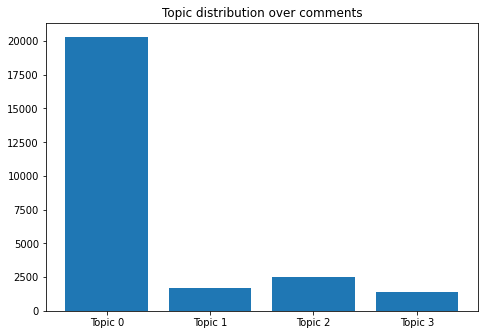

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

topic_count = data_topic_keywords['Dominant_Topic'].value_counts()

x = []
y = []

for i, topic in enumerate(topic_count):
    y.append(float(topic_count[i]))
    x.append('Topic {}'.format(i))

ax.bar(x,y)
ax.set_title('Topic distribution over comments')
plt.show()

#### Show topic distribution for single comment

In [34]:
get_document_topics = tuned_lda_model.get_document_topics(corpus)

In [35]:
comment_id = int(input())

get_document_topics[comment_id]

890


[(0, 0.38961038), (1, 0.2597403), (2, 0.19480519), (3, 0.15584417)]

## Contextual Embeddings

### USE

In [ ]:
%%capture
!pip3 install seaborn

In [ ]:
data['cleaned']

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed(data['cleaned'])

print(embeddings)

In [ ]:
from itertools import islice
import numpy as np

limit = 5

for i, comment_embedding in islice(enumerate(np.array(embeddings).tolist()), limit):
  print("Comment: {}".format(data['cleaned'][i]))
  print("Embedding size: {}".format(len(comment_embedding)))
  comment_embedding_snippet = ", ".join(
      (str(x) for x in comment_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(comment_embedding_snippet))

Plots and prints a heat map showing the semantic contextual similarity. 

TODO: Try on subset of data. 

In [ ]:
import seaborn as sns

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

Cosine similarity matrix


Calculating the cosine angle between two vectors. If two vectors are similar, the angle between them is small, and the cosine similarity value is closer to 1.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity

cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

Top N similar comments

In [ ]:
comment = data["cleaned"][492]
comment_list = data["cleaned"].tolist()
print(comment)

In [ ]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 5)):
  print("Top similar comment {}: {}".format(i+1, value))

### BERT